In [2]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [3]:
env = BlackjackEnv()

In [4]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    
    def policy_fn(observation):
        greedy_action = np.argmax(Q[observation])

        if epsilon > np.random.random():
            # take the random action
            action_value = np.random.randint(0, nA)
            decision = np.eye(nA)[action_value]
        else:
            # take the greedy action
            decision = np.eye(nA)[greedy_action]

        return decision

    return policy_fn

In [5]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon,env.action_space.n)
    
    for espisode in range(num_episodes):
        observation = env.reset()
        observation_list = list()
        action_list = list()
        reward_list = list()

        action = np.random.randint(0, env.action_space.n)
        # Generate an episode following ⇡: (S0, A0, R1), (S1, A1, R2), . . . , (ST-1, AT-1, RT)
        for t in range(100):
            observation_list.append(observation)
            action_list.append(action)

            observation, reward, done, _ = env.step(action)

            reward_list.append(reward)

            action = np.random.choice(np.arange(0, env.action_space.n), p=policy(observation))

            if done:
                break
        
        G = 0
        # Loop for each step of episode, t = T-1,T-2,...,0:
        for i in range(len(observation_list) -1, -1, -1):
            # G = ∂G + Rt+1
            G = discount_factor * G + reward_list[i]
            # Unless St appears in S0,S1,...,St-1:
            # Append G to Returns(St)
            if observation_list[i] not in observation_list[:i]:
                returns_sum[(observation_list[i], action_list[i])] += G
                returns_count[(observation_list[i], action_list[i])] += 1
                Q[observation_list[i]][action_list[i]] = \
                    returns_sum[(observation_list[i], action_list[i])] / returns_count[(observation_list[i], action_list[i])]
                
                policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)

    return Q, policy

In [6]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

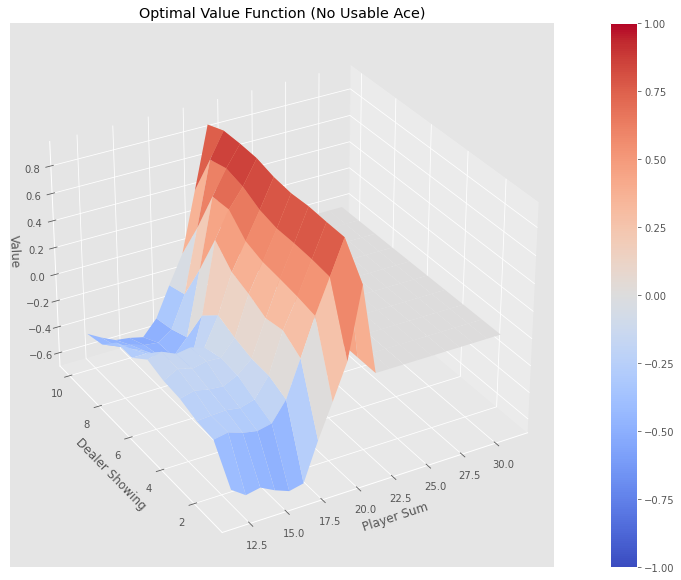

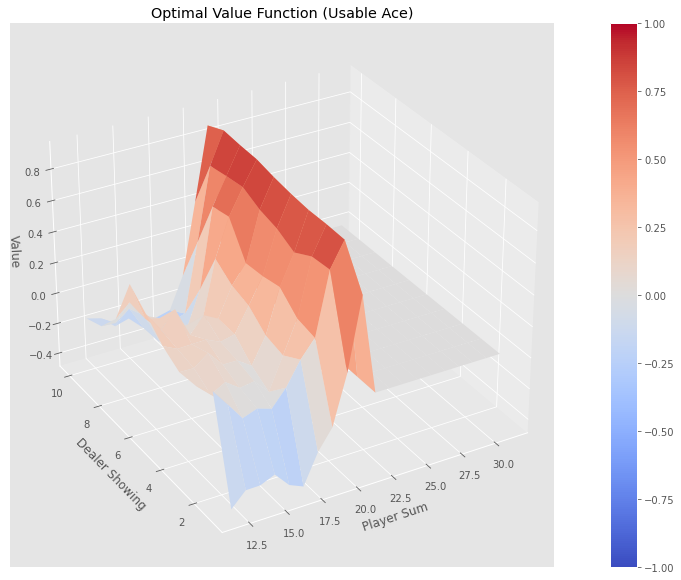

In [14]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")